In [1]:
"""
Solving the Taxi RL Problem Using DQN

Heavily inspired (with slight modifications) from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
"""
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, OrderedDict, Sequence
from itertools import count

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [3]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [18]:
class DQNUnFancy(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self._layer1 = nn.Linear(input_dim, 48)
        self._layer2 = nn.Linear(48, 32)
        self._layer3 = nn.Linear(32, 32)
        self._output_layer = nn.Linear(32, output_dim)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self._layer1(x))
        x = F.relu(self._layer2(x))
        x = F.relu(self._layer3(x))
        x = self._output_layer(x)
        return x

In [19]:
class DQN(nn.Module):

    def __init__(self, input_dim, output_dim, layer_config=None, non_linearity='relu'):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layer_config = self.form_layer_config(layer_config)
        self.non_linearity = non_linearity
        self.compose_model()

    def get_default_config(self):
        return [
            [self.input_dim, 48],
            [48, 32],
            [32, 32],
            [32, self.output_dim]
        ]
    
    def form_layer_config(self, layer_config):
        if layer_config is None:
            return self.get_default_config()
        
        if len(layer_config) < 2:
            raise ValueError("Layer config must have at least two layers")

        if layer_config[0][0] != self.input_dim:
            raise ValueError("Input dimension of first layer config must be the same as input to the model")

        if layer_config[-1][1] != self.output_dim:
            raise ValueError("output dimension of last layer config must be the same as expected model output")
            
        for idx in range(len(layer_config) - 1):
            assert layer_config[idx][1] == layer_config[idx], "Dimension mismatch between layers %d and %d" (idx, idx+1)
        
        return layer_config

    def get_non_linear_class(self):
        if self.non_linearity == 'tanh':
            return nn.Tanh
        else:
            return nn.ReLU

    def compose_model(self):
        non_linear = self.get_non_linear_class()
        layers = OrderedDict()
        for idx in range(len(self.layer_config)):
            input_dim, output_dim = self.layer_config[idx]
            layers['linear-%d' % idx] = nn.Linear(input_dim, output_dim)
            if idx != len(self.layer_config) - 1:
                layers['nonlinear-%d' % idx] = non_linear()
        
        self.model = nn.Sequential(layers)
    
    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.model(x)


In [20]:
class TaxiAgentUnFancy:
    def __init__(self, env, input_dim, output_dim, **kwargs):
        self.env = env
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_actions = output_dim
        self.layer_config = kwargs.get('layer_config', None)
        self.batch_size = kwargs.get('batch_size', 1)
        self.gamma = kwargs.get('gamma', 0.999)
        self.eps_start = kwargs.get('eps_start', 0.9)
        self.epsilon = self.eps_start
        self.eps_end = kwargs.get('eps_end', 0.05)
        self.eps_decay = kwargs.get('eps_decay', 200)
        self.target_update = kwargs.get('target_update', 10)
        self.replay_capacity = kwargs.get('replay_capacity', 10)
        self.non_linearity = kwargs.get('non_linearity', 'relu')
        self.optimiser_name = kwargs.get('optimiser_name', 'rmsprop')
        self.optimiser_params = kwargs.get('optimiser_params', {})

        self.memory = ReplayMemory(self.replay_capacity)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.steps_done = 0

        self.policy_network = DQN(self.input_dim, self.output_dim).to(self.device)
        self.target_network = DQN(self.input_dim, self.output_dim).to(self.device)

        # we aren't interested in tracking gradients for the target network
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        self.optimiser = optim.RMSprop(self.policy_network.parameters())

        self.state = None
        self.reset_env()
    
    def reset_env(self):
        self.env.reset()
        self.state = self.state_to_tensor(self.env.s)
    
    def state_to_tensor(self, state):
        if not isinstance(state, Sequence):
            state = list(self.env.decode(state))
        else:
            state = state.copy()
        
        return torch.tensor(state, device=self.device, dtype=torch.float).reshape(-1, self.input_dim)

    def get_optimiser(self):
        if self.optimiser_name == 'sgd':
            optimiser = optim.RMSprop
        elif self.optimiser_name == 'adam':
            optimiser = optim.Adam
        else:
            optimiser = optim.RMSprop
        
        return optimiser
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)

        # see https://stackoverflow.com/a/19343/3343043 for detailed explanation
        batch = Transition(*zip(*transitions))

        loss = self.compute_loss(batch)

        self.optimiser.zero_grad()
        loss.backward()

        for param in self.policy_network.parameters():
            param.grad.data.clamp_(-1, 1)
        
        self.optimiser.step()

        return loss
    
    def double_q_update(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def compute_loss(self, batch):
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
            batch.next_state)), device=self.device, dtype=torch.bool)

        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_network(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=self.device)


        next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        return loss
    
    def select_action(self, state):
        sample = random.random()

        if sample < self.epsilon:
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)
        else:
            with torch.no_grad():
                return self.policy_network.forward(state).max(1)[1].view(1, 1)
    

    def decay_epsilon(self):
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-1. * self.steps_done/self.eps_decay)
    
    def step(self):
        state = self.state
        self.decay_epsilon()
        self.steps_done += 1

        action = self.select_action(state)
        
        next_state, _reward, done, _ = self.env.step(action.item())
        next_state = self.state_to_tensor(next_state)
        reward = torch.tensor([_reward], device=self.device)

        self.memory.push(state, action, next_state, reward)
        self.state = next_state

        return _reward, done

In [21]:
class TaxiAgent:
    def __init__(self, env, input_dim, output_dim, **kwargs):
        self.env = env
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_actions = output_dim
        self.layer_config = kwargs.get('layer_config', None)
        self.batch_size = kwargs.get('batch_size', 1)
        self.gamma = kwargs.get('gamma', 0.999)
        self.eps_start = kwargs.get('eps_start', 0.9)
        self.epsilon = self.eps_start
        self.eps_end = kwargs.get('eps_end', 0.05)
        self.eps_decay = kwargs.get('eps_decay', 200)
        self.target_update = kwargs.get('target_update', 10)
        self.replay_capacity = kwargs.get('replay_capacity', 10)
        self.non_linearity = kwargs.get('non_linearity', 'relu')
        self.optimiser_name = kwargs.get('optimiser_name', 'rmsprop')
        self.optimiser_params = kwargs.get('optimiser_params', {})

        self.memory = ReplayMemory(self.replay_capacity)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.steps_done = 0

        self.policy_network = DQN(self.input_dim, self.output_dim, self.layer_config, self.non_linearity).to(self.device)
        self.target_network = DQN(self.input_dim, self.output_dim, self.layer_config, self.non_linearity).to(self.device)

        # we aren't interested in tracking gradients for the target network
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        optimiser_cls = self.get_optimiser()
        self.optimiser = optimiser_cls(self.policy_network.parameters(), **self.optimiser_params)

        self.state = None
        self.reset_env()
    
    def reset_env(self):
        self.env.reset()
        self.state = self.state_to_tensor(self.env.s)
    
    def state_to_tensor(self, state):
        if not isinstance(state, Sequence):
            state = list(self.env.decode(state))
        else:
            state = state.copy()
        
        return torch.tensor(state, device=self.device, dtype=torch.float).reshape(-1, self.input_dim)

    def get_optimiser(self):
        if self.optimiser_name == 'sgd':
            optimiser = optim.RMSprop
        elif self.optimiser_name == 'adam':
            optimiser = optim.Adam
        else:
            optimiser = optim.RMSprop
        
        return optimiser
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)

        # see https://stackoverflow.com/a/19343/3343043 for detailed explanation
        batch = Transition(*zip(*transitions))

        loss = self.compute_loss(batch)

        self.optimiser.zero_grad()
        loss.backward()

        for param in self.policy_network.parameters():
            param.grad.data.clamp_(-1, 1)
        
        self.optimiser.step()

        return loss
    
    def double_q_update(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def compute_loss(self, batch):
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
            batch.next_state)), device=self.device, dtype=torch.bool)

        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_network.forward(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=self.device)


        next_state_values[non_final_mask] = self.target_network.forward(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        return loss
    
    def select_action(self, state):
        sample = random.random()

        if sample < self.epsilon:
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)
        else:
            with torch.no_grad():
                return self.policy_network.forward(state).max(1)[1].view(1, 1)
    

    def decay_epsilon(self):
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * np.exp(-1 * self.steps_done/self.eps_decay)
    
    def step(self):
        state = self.state
        action = self.select_action(state)

        self.steps_done += 1

        self.decay_epsilon()
        
        
        next_state, _reward, done, _ = self.env.step(action.item())
        next_state = self.state_to_tensor(next_state)
        reward = torch.tensor([_reward], device=self.device)

        self.memory.push(state, action, next_state, reward)
        self.state = next_state

        return _reward, done

In [6]:
class Bench:
    def __init__(self, agent, num_episodes=50):
        self.agent = agent
        self.rewardList = []
        self.episode_duration = []
        self.episode_loss = []
        self.num_episodes = num_episodes
    
    def run_trial(self, debug=True):
        for idx in range(self.num_episodes):
            self.agent.reset_env()
            rewards = 0
            for jdx in count():
                if debug and jdx % 10000 == 0:
                    print("Running timestep: %d for episode: %d" % (jdx, idx))
                reward, done = self.agent.step()
                # optimize
                loss = self.agent.update()
                self.episode_loss.append(loss)
                rewards += reward
                if done:
                    num_runs = jdx + 1
                    self.episode_duration.append(num_runs)
                    self.rewardList.append(rewards)
                    break
            if idx % self.agent.target_update == 0:
                self.agent.double_q_update()

In [7]:
env = gym.make("Taxi-v3").env

In [8]:
input_dim = 4
output_dim = 6
agent = TaxiAgent(env, input_dim, output_dim)

In [9]:
bench = Bench(agent)

In [10]:
bench.run_trial()

Running timestep: 0 for episode: 0
Running timestep: 0 for episode: 1
Running timestep: 10000 for episode: 1
Running timestep: 0 for episode: 2
Running timestep: 10000 for episode: 2
Running timestep: 0 for episode: 3
Running timestep: 10000 for episode: 3
Running timestep: 20000 for episode: 3
Running timestep: 30000 for episode: 3
Running timestep: 40000 for episode: 3
Running timestep: 50000 for episode: 3
Running timestep: 60000 for episode: 3
Running timestep: 70000 for episode: 3
Running timestep: 80000 for episode: 3
Running timestep: 90000 for episode: 3
Running timestep: 100000 for episode: 3
Running timestep: 110000 for episode: 3
Running timestep: 120000 for episode: 3
Running timestep: 130000 for episode: 3
Running timestep: 140000 for episode: 3
Running timestep: 150000 for episode: 3
Running timestep: 160000 for episode: 3
Running timestep: 170000 for episode: 3
Running timestep: 0 for episode: 4
Running timestep: 10000 for episode: 4
Running timestep: 20000 for episode: 

In [11]:
# build up the q-table using the network!
q_table = np.zeros((env.nS, env.nA))

In [12]:
with torch.no_grad():
    for idx in range(env.nS):
        s = agent.state_to_tensor(idx)
        q_values = agent.policy_network(s)
        q_values = q_values.detach().numpy()
        q_table[idx] = q_values

In [15]:
q_table[0]

array([ -5.35347414,  -5.3162179 ,  -5.30059767,  -5.30166054,
       -14.45737267, -14.48056984])

In [16]:
import matplotlib.pyplot as plt

In [22]:
loss = bench.episode_loss

In [28]:
losses = [_.item() for _ in bench.episode_loss]

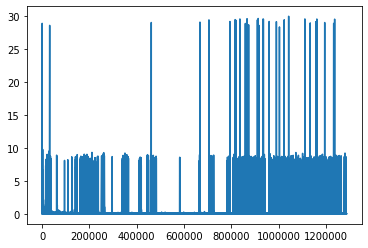

In [29]:
plt.plot(range(len(losses)), losses)

In [ ]:
np.random